Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 13: Unsupervised Learning - Clustering

J.B. Scoggins, Jesse Read, Adrien Ehrhardt, Johannes Lutzeyer, Jérémie Decock

## Introduction

In this lab, you will implement two unsupervised learning algorithms to cluster data points based on similarity criteria: k-means, and spectral clustering. While libraries such as scikit-learn provide facilities that implement these algorithms, they are simple enough for you to implement with numpy alone, which will allow you to gain a better understanding of them in practice. Before you begin, import the required packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from random import randrange
import networkx as nx

### Datasets

Throughout this lab, you will use 4 simple datasets to test your algorithms. Run the code below to visualize each dataset. As you can see, the first dataset consists of 4 normally-distributed clusters of points with equal variance. The second represents two clusters, one stretched vertically, and one horizontally. The third dataset represents 4 clusters with different variances. Finally, the last dataset represents 3 clusters distributed in rings. For convenience, the three datasets are placed in a list called `datasets`. In the rest of the lab, you will be asked to implement 2 clustering algorithms and run them on these datasets.

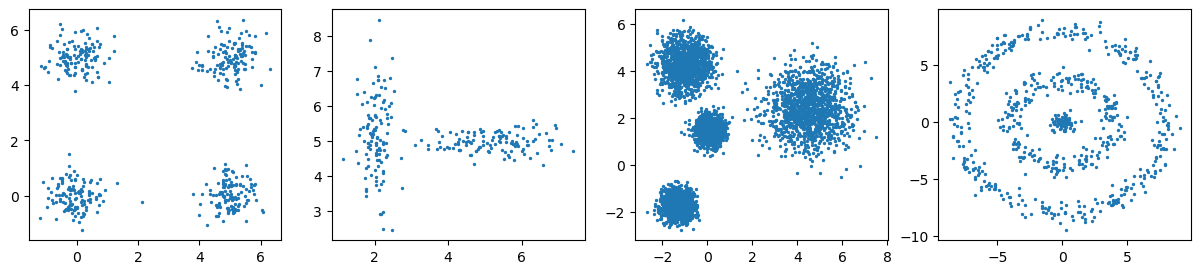

In [2]:
# Create a data set
N = 120

data1 = np.random.normal((0, 0), (0.5, 0.5), size=(N, 2))
data1 = np.append(data1, np.random.normal((5,0), (0.5, 0.5), size=(N, 2)), axis=0)
data1 = np.append(data1, np.random.normal((0,5), (0.5, 0.5), size=(N, 2)), axis=0)
data1 = np.append(data1, np.random.normal((5,5), (0.5, 0.5), size=(N, 2)), axis=0)

data2 = np.random.normal((2, 5), (0.25, 1), size=(N, 2))
data2 = np.append(data2, np.random.normal((5, 5), (1, 0.25), size=(N, 2)), axis=0)

np.random.seed(2604)
mus = np.random.uniform(-5, 5, size=(4,2))
sigmas = np.random.uniform(-0.7, 0.7, size=(4,2))
X = []
for k in range(4):    
    X.append(np.random.normal(mus[k,:],sigmas[k,:] @ sigmas[k,:].T,size=(int(5000/4),2)))
data3 = np.concatenate([X]).reshape(-1,2)

radii = np.random.normal(0, 0.5,size=(N, 1))
radii = np.append(radii, np.random.normal(4, 0.5,size=(2 * N, 1)), axis=0)
radii = np.append(radii, np.random.normal(8, 0.5,size=(3 * N, 1)), axis=0)
angles = np.random.uniform(size=(6 * N, 1)) * 2.0 * np.pi
data4 = np.hstack([radii * np.cos(angles), radii * np.sin(angles)])

datasets = [data1, data2, data3, data4]

fig, axes = plt.subplots(1, len(datasets), figsize=(15, 3))
for i,data in enumerate(datasets):
    axes[i].scatter(data[:, 0], data[:, 1], s=2)

## Part 1: The k-Means Algorithm

k-means is one of the simplest unsupervised learning algorithms that solves the well-known clustering problem. The algorithm defines an iterative process, where the following two steps are repeated at each iteration:
1. take each instance belonging to the dataset and assign it to the nearest centroid, and
2. re-calculate the centroids of each of the k clusters.

Thus, the k centroids change their location step by step until convergence, i.e., nothing changes anymore.

More formally, suppose that we are given a dataset $\mathbf{X} = \Big( \boldsymbol{x}_1, \dots, \boldsymbol{x}_n \Big)$, where each $\boldsymbol{x}_i \in \mathbb{R}^d$. The goal of the k-means algorithm is to group the data into $k$ cohesive clusters, where $k$ is an input parameter of the algorithm. **Your task is to implement this algorithm**. Algorithm 1 gives the pseudocode.

___
### Algorithm 1: k-means

**Input**: The dataset $\mathbf{X} = \Big( \boldsymbol{x}_1, \dots, \boldsymbol{x}_n \Big)$ (where each $\boldsymbol{x}_i \in \mathbb{R}^d$) and the hyper-parameter $k$ (the number of clusters).<br>

1. Initialize cluster centroids ${\boldsymbol\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_k$ by choosing $k$ instances of $\mathbf{X}$ randomly;

**Repeat:**

2. Assign each instance $\boldsymbol{x}_i \in \mathbf{X}$ to the closest centroid, i.e., $c_i = \text{argmin}_{z\in\{1, \ldots, k\}} \|\boldsymbol{x}_i - \boldsymbol{\mu}_z\|_2$;

3. Re-compute the centroids $\boldsymbol{\mu}_1, \ldots, \boldsymbol{\mu}_k$ of each cluster based on $\boldsymbol{\mu}_z = \Big(\sum_{\boldsymbol{x} \in \mathbf{C}_z} \boldsymbol{x}\Big)/|\mathbf{C}_z|$, where $\mathbf{C}_z = \{\boldsymbol{x}_i | c_i = z\}$ the $z$-th cluster with $z=1, \ldots, k$ and $|\mathbf{C}_z|$ the number of instances in the $z$-th cluster.

**until** Centroids do not change (convergence).

**Output**: Clusters assignments (the cluster assigned to each element of $\mathbf{X}$).

___

In the algorithm above, $k$ is a parameter of the algorithm and corresponds to the number of clusters we want to find; the cluster centroids $\boldsymbol{\mu}_z$ represent our current guesses for the positions of the centers of the clusters. To initialize the cluster centroids (in step 1 of the algorithm), we could choose $k$ training examples randomly (without replacement such that these are initially different), and set the cluster centroids to be equal to the values of these $k$ examples. 

Based on its notion of similarity, the problem of $k$-means clustering can be reduced to the problem of finding appropriate centroids. This, in turn, can be expressed as the task of minimizing the following objective function:
$$
     E(k) = \sum_{z=1}^{k} \sum_{\boldsymbol{x}_i \in \mathbf{C}_z}\| \boldsymbol{x}_i - \boldsymbol{\mu}_z \|_2^2.
$$

**Exercise 1:** Implement both the `euclidean_distance`function and the `k_means` function below.

In [3]:
def euclidean_distance(X1: np.ndarray, X2: np.ndarray) -> np.ndarray:
    """
    Distance Function
    -----------------
    Computes the Euclidean distance between two arrays of points.

    Return
    ------
    A 2D n by m array where entry [i, j] is the distance 
    from the i-th point in X1 to the j-th point in X2.
    """
    n = X1.shape[0]  
    m = X2.shape[0]  
    distances = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            distances[i, j] = np.linalg.norm(X1[i] - X2[j])

    return distances

*Python hints (providing functions that may be of help when implementing the `k_means` function)*:
   * [`numpy.random.choice()`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html)
   * [`numpy.argmin()`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html)
   * [`numpy.min()`](https://numpy.org/doc/stable/reference/generated/numpy.amin.html)
   * [`numpy.mean()`](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)

In [4]:
def k_means(X: np.ndarray, k: int, centroid_indices: list or np.ndarray = None):
    """
    Parameters
    ----------
    X : an n-by-d matrix of inputs
    k : the number of clusters to find
    centroid_indices : indices of points in X chosen as centroids (we'll use this argument later)


    Algorithm:
    ----------
    1. Initialize (choose) the centroids
    2. Implement a `while` loop such that, while centroids have not changed since the last iteration:
        - compute the distances of all points to each centroid
        - label each point (associate it with) the nearest centroid
        - recompute the centroids (i.e., average of points belonging to each centroid)

    Return
    ------
    Tuple (z, iters, err)

    z : a 1D vector of labels of length n (e.g. z[i] = C_z means "x_i is belongs to cluster C_z")
    iters : the number of iterations carried out until convergence
    err: the error E(k)
    """
    n = X.shape[0]
    if centroid_indices is None: 
        centroid_indices = np.random.choice(range(n), k, replace=False)  
    centroids = X[centroid_indices, :]
    iters = 0
    prev_centroids = None
    while True:
        
        distances = euclidean_distance(X, centroids)
        z = np.argmin(distances, axis=1)
        prev_centroids = centroids.copy()
        for i in range(k):
            mask = (z == i)
            if np.any(mask):
                centroids[i] = np.mean(X[mask], axis=0)
        if np.all(prev_centroids == centroids):
            break
        iters += 1
    err = np.sum(np.min(distances, axis=1))
    return z, iters, err

To test your implementation, run the following code which will plot the 4 datasets, trying different values of $k$. It will display the number of iterations until convergence (along with $k$ in the title). 

**Exercise 2:** Comment in the following cell if the k-means algorithm was able to recover the cluster structure that we are intituively able to observe in the 2 dimensional plots.

*Note*: since there is some randomness (in the intial choice of centroids), re-running this code will give different results!

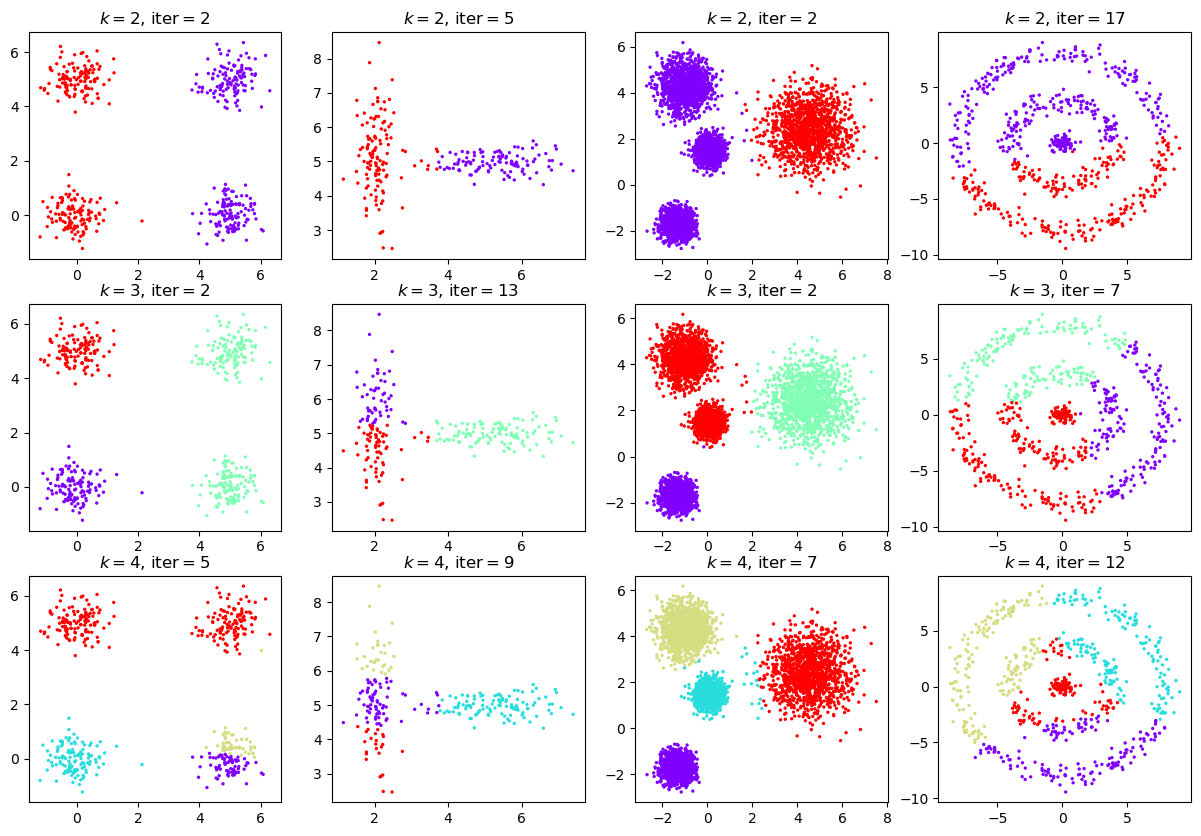

In [5]:
fig, axes = plt.subplots(3, len(datasets), figsize=(15, 10))
for i, k in enumerate([2, 3, 4]):
    for j, data in enumerate(datasets):
        labels, iters, err = k_means(data, k)
        axes[i, j].scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', s=2)
        axes[i, j].set_title('$k=%d$, iter$=%d$' % (k, iters))

For the first dataset, we see that for k=4, the model could indentify foour coherent clusters. For k=3, we see that, while we have 2 centroids in the center of their respective clusters, one of them is in the middle of the two clusters, thus labelling them as one group. Therefore, it is important to have a good k.
For the second dataset, we do not know if the clusters for k=3 and k=4 are representative. However, we can infer that for k=2, the clustering makes sense.
For the third dataset, we have a pretty good clustering for k=4, with some errors.
For the fourth dataset, we do not really have a good clustering. 

To minimize the function $E(k)$, we wish to determine suitable centroids $(\boldsymbol{\mu}_z)_1^k$ such that, if the data is partitioned into corresponding clusters $(\mathbf{C}_z)_1^k$, distances between data points and their closest cluster centroid become as small as possible.

The convergence of the $k$-means algorithm is highly dependent on the initialization of the centroids. It may converge to a local minimum of the objective function $E(k)$. One way to overcome this problem is to execute the algorithm several times, with different initializations of the centroids. 

Another issue is how to determine the number of clusters ($k$) of the dataset. Intuitively, increasing $k$ without penalty will always reduce the amount of error in the resulting clustering, to the extreme case of zero error if each data point is in its own cluster (*i.e.*, when $k=n$). A method to determine $k$ is the *elbow rule*, similar to the one we used in the previous lab for determining the number of principal components to retain. The idea is to examine  and compare the error given above for a number of cluster solutions. In general, as the number of clusters increases, the *sum of squared errors* (SSE) should decrease because clusters are, by definition, smaller. A plot of the SSE against a series of sequential cluster levels (*i.e.*, different values) can be helpful here. That is, an appropriate cluster solution could be defined as the one where the reduction in SSE slows dramatically. This produces an "elbow" in the plot of SSE against the different values of $k$.  The "elbow" in such a plot is generally considered as an indicator of the appropriate number of clusters to choose. 

**Exercise 3:** Implement the elbow rule to find an appropriate value for $k$, as follows:

For $k\in \{1,\ldots,7\}$, run the k-means algorithm (defined above as Algorithm 1 and implemented in `k_means`) **10 times** and log their total intra-cluster error ($E(k)$, given above, and last output of `k_means`). Then, for each $k$ compute the **mean total intra-cluster error over all 10 runs** and plot these seven mean total intra-cluster errors against the parameter $k.$ 

In [6]:
def plot_error(dataset: np.ndarray):
    costs = []  # fill costs with the average total intra-cluster error over all 10 runs for each k in k_list
    k_list = range(1, 8)
    
    for k in k_list:
        total_error = 0
        for _ in range(10):
            z, _, err = k_means(dataset, k)
            total_error += err
        mean_error = total_error / 10
        costs.append(mean_error)
    log_costs = np.log(costs)  # Compute the logarithm of the mean errors
    
    plt.plot(k_list, log_costs)
    plt.xlabel('$k$')
    plt.show()

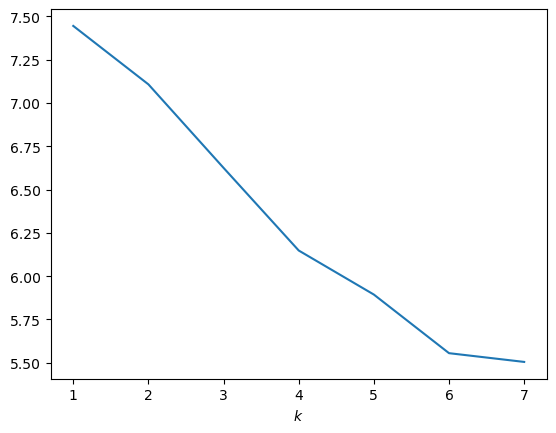

In [7]:
plot_error(datasets[0])

**Exercise 4:** Based on this plot, which value of $k$ do you retain for the first dataset?

We see that the "elbow" is identified for k=4

As you might have noticed the random sampling of the cluster centroids introduces a significant amount of stochasticity in the k-means results. The results of the k-means algorithm tend to be improved and slightly more stable, when a more elaborate initialisation scheme is chosen for the cluster centers. The most prevalent of these alternative intialisation schemes is the [kmeans++ technique](https://en.wikipedia.org/wiki/K-means%2B%2B). In the improved k-means++ algorithm the centroids are sampled one by one with the first centroid being chosen at a random data point. Further, if we let $d_i$ denote the Euclidean distance of datapoint $x_i$ to its closest, already sampled, centroid, then the probability of data point $x_i$ being chosen as the next centroid is equal to $\frac{d_i^2}{\sum_{i=1}^n d_i^2}.$  


**Exercise 5:** Implement the k-means++ initialization algorithm. (Hint: you can make use of ```np.random.multinomial``` to sample the index of the next centroid in the k-means++ initialisation scheme. )

In [8]:


def k_means_plus_plus_init(X: np.ndarray, k: int):
    """
    Parameters
    ----------
    X : an n-by-d matrix of inputs
    k : the number of clusters to find

    Algorithm:
    ----------
    1. Initialize (choose) the centroids according to the k-means++ algorithm

    Return
    ------
    centroid indices (list or np.ndarray), e.g. [1, 10] if X[1, :] and X[10, :]
    are chosen as centroids for k=2
    """
    
    n = X.shape[0]  
    centroid_indices = [np.random.randint(n)]  
    for _ in range(1, k):
        distances = np.min(euclidean_distance(X, X[centroid_indices]), axis=1) ** 2  
        probs = distances / np.sum(distances) 
        next_centroid = np.random.multinomial(1, probs)  
        centroid_indices.append(np.argmax(next_centroid))  
    return centroid_indices


**Exercise 6:** Execute the below code cell several times and comment on whether you notice any differences compared to the results produced in Exercise 2. 

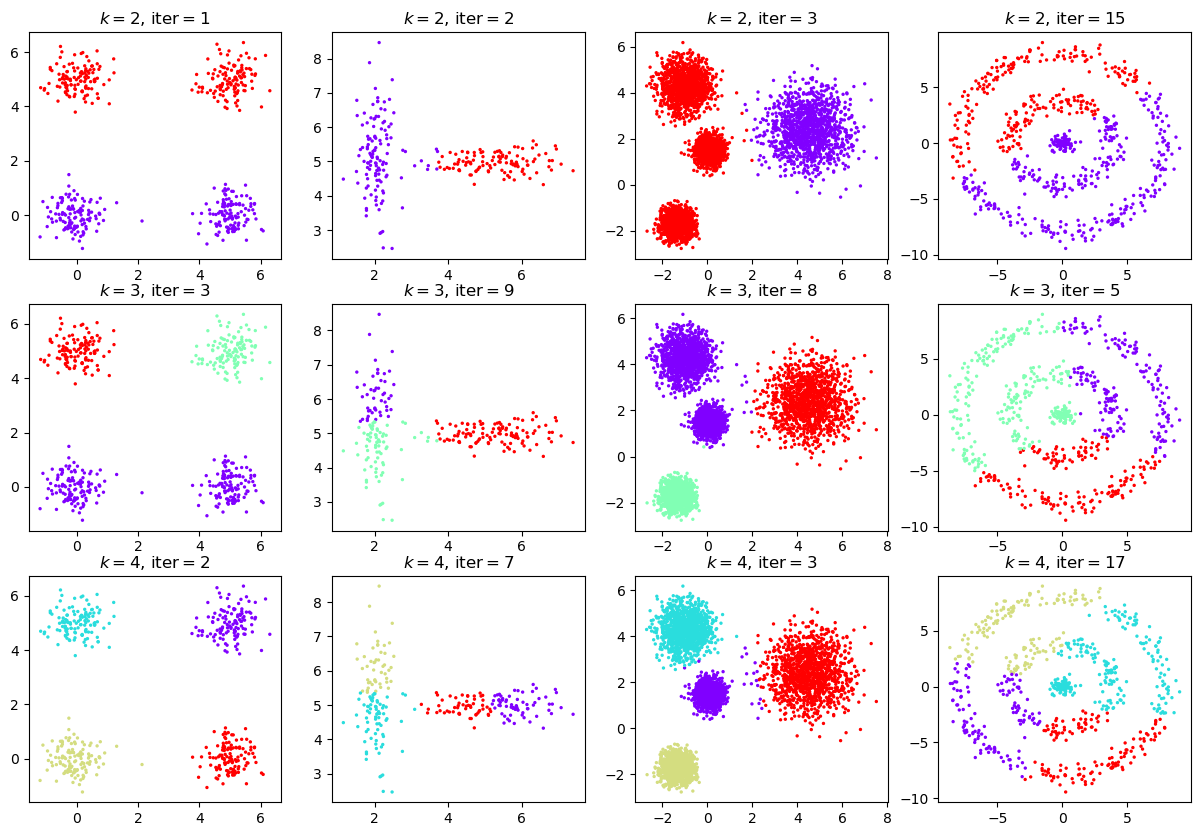

In [9]:
fig, axes = plt.subplots(3, len(datasets), figsize=(15, 10))
for i,k in enumerate([2, 3, 4]):
    for j, data in enumerate(datasets):
        centroid_centers_kmeans_plus = k_means_plus_plus_init(data, k)
        labels, iters, err = k_means(data, k, centroid_centers_kmeans_plus)
        axes[i,j].scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', s=2)
        axes[i,j].set_title('$k=%d$, iter$=%d$' % (k, iters))

The results look similar to the ones in Exercise 2. Only now, the model find the clusters in less iterations, since we used probablities instead of selecting the centroids randomly.

## Part 2: Spectral Clustering

The Spectral clustering algorithm makes use of the *spectrum* (eigenvalues) and eigenvectors of a similarity matrix of the data to perform dimensionality reduction before clustering in fewer dimensions. The similarity matrix is provided as an input and consists in a quantitative assessment of the relative similarity of each pair of points in the dataset.

Given a set of data points $\boldsymbol{x}_1, \ldots ,\boldsymbol{x}_n, \forall \boldsymbol{x}_i \in \mathbb{R}^d$ and some notion of similarity $s_{ij}$ between all pairs of data points $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$, the intuitive goal of clustering is to divide the data points into several groups such that points in the same group are similar and points in different groups are dissimilar to each other. If we do not have more information than similarities between data points, a nice way of representing the data is in form of the similarity graph $G = (V, E)$. Each vertex $v_i$ in this graph represents a data point $\boldsymbol{x}_i$. Two vertices are connected if the similarity $s_{ij}$ between the corresponding data points $\boldsymbol{x}_i$ and $\boldsymbol{x}_j$ is positive or larger than a certain threshold, and the edge is weighted by $s_{ij}$. The problem of clustering can now be reformulated using the similarity graph: we want to find a partition of the graph such that the edges between different groups have very low weights (which means that points in different clusters are dissimilar from each other) and the edges within a group have high weights (which means that points within the same cluster are similar to each other).

### Creating the similarity graph

There are several popular constructions to transform a given set $\boldsymbol{x}_1, \ldots , \boldsymbol{x}_n, \forall \boldsymbol{x}_i \in \mathbb{R}^d$ of data points with pairwise
similarities $w_{ij}$ or pairwise distances $d_{ij}$ into a graph. When constructing similarity graphs the goal is to model the local neighborhood relationships between the data points. We will see two such heurtistic similarity graph constructions.

1) We use the approach of the $k$-Nearest Neighbors graph. Here the goal is to connect vertex $\boldsymbol{x}_i$ with vertex $\boldsymbol{x}_j$ by an undirected edge if either $\boldsymbol{x}_j$ is among the $k$-nearest neighbors of $\boldsymbol{x}_i$ or $\boldsymbol{x}_i$ is among the $k$-nearest neighbors of $\boldsymbol{x}_j$. 

2) We work with a weighted fully connected graph. In a fully connected graph all vertices, i.e., data points, are connected by an edge. In this graph construction we choose to attribute an edge weight with each edge, which will be determined by a Gaussian kernel $  K_{Gauss}(x_i, x_j) = \exp\left( - \frac{\| x_i - x_j\|^2}{2 \sigma^2}\right)$ on the two connected data points. 

**Exercise 7:** We now ask you to complete the `knn_graph` and `gaussianKernel_graph` functions below. These should take as input a set of data points and return the adjacency matrix of the corresponding similarity graph. The adjacency matrix contains a zero in entry $ij$ if data points $x_i$ and $x_j$ are not connected by an edge and contains a non-zero weight $w_{ij}$ if data points $x_i$ and $x_j$ are connected by an edge with weight $w_{ij}$ (Note that if the graph is unweighted such as the $k$-Nearest Neighbors graph, then all edge weights are equal to 1 by convention).

*Python hints:*

* to find the `k` nearest neighbors of each $\boldsymbol{x}_i \in \mathbf{X}$, the function [`np.argpartition`](https://numpy.org/doc/stable/reference/generated/numpy.argpartition.html) may turn out to be useful.


In [10]:
def knn_graph(X, neighbours):
    """
    Args:
        X (np.array, n x p):  data points
        neighbours (int): number of nearest neighbours to be considered for each node
    
    Returns:
        A (np.array, n x n): the adjacency matrix of the knn graph
    """    
    n = X.shape[0]
    A = np.zeros((n, n))

    for i in range(n):
        distances = np.linalg.norm(X[i] - X, axis=1)  
        indices = np.argpartition(distances, neighbours)[:neighbours]  
        A[i, indices] = 1  

    return A

In [11]:
def gaussianKernel_graph(X, sigma = 0.1):
    """
    Args:
        X (np.array, n x p):  data points
    
    Returns:
        A (np.array, n x n): the adjacency matrix of the Gaussian similarity graph
    """    
    n = X.shape[0]
    A = np.zeros((n, n))

    distances = euclidean_distance(X, X)  # Calculate pairwise distances using the euclidean_distance function

    for i in range(n):
        for j in range(n):
            if i != j:
                distance = distances[i, j]  # Get the precomputed distance from the matrix
                weight = np.exp(-distance**2 / (2 * sigma**2))  # Calculate Gaussian kernel weight
                A[i, j] = weight  # Set the weight in the adjacency matrix

    return A

You may test your `knn_graph` in the following cell:

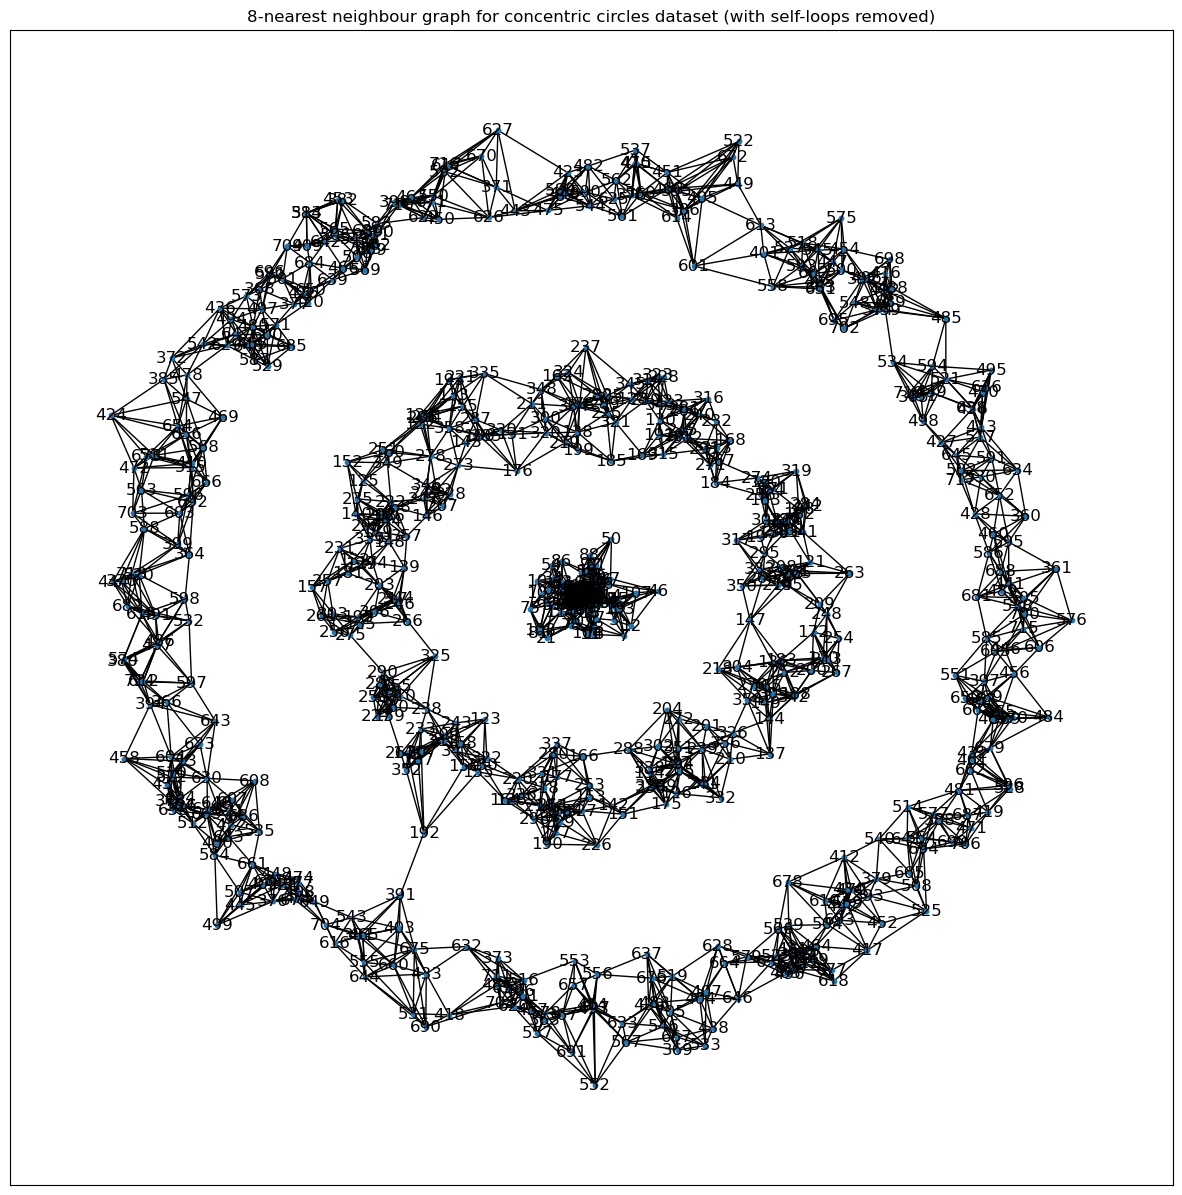

In [12]:
A_concentric = knn_graph(datasets[3], 8)
    
plt.figure(1, figsize=(15, 15))
G = nx.from_numpy_matrix(A_concentric - np.eye(A_concentric.shape[0]))
nx.draw_networkx(G, pos=datasets[3], node_size=10)
plt.title("%d-nearest neighbour graph for concentric circles dataset (with self-loops removed)" %(8));

### The algorithm

The pseudocode of the spectral clustering algorithm is given as follows. In spectral clustering, the data is projected into a lower-dimensional space (the spectral/eigenvector domain) where they are easily separable, say using $k$-means.

Given a dataset $\mathbf{X}=\{ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n\}$, where  each $\boldsymbol{x}_i \in \mathbb{R}^d$, hyper-parameter $k$ and a choice of similarity graph construction:

1. Construct the similarity graph $G$ as described above. Let
    * $\mathbf{A} = (w_{ij})_1^n$ be the adjacency matrix of this graph.
    * $\mathbf{D}$ be the diagonal degree matrix of graph $G$, ie $\mathbf{D}_{ii} = \sum_j {w}_{ij}$ and $\mathbf{D}_{ij} = 0$ for $i \neq j$.
2. Compute the random walk normalised Laplacian $L_{rw} = I - D^{-1}A$ (note other matrix choices are possible here).
3. Apply[ eigenvalue decomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) to the Laplacian matrix $\mathbf{L}$.
4. Select the eigenvectors which correspond to $k$ smallest eigenvalues, which we denote by $\mathbf{U}$.
5. Apply $k$-means to $\mathbf{U}$ (as if the rows were instances / samples), thus finding clusters $\mathbf{C}_1, \mathbf{C}_2, \ldots, \mathbf{C}_k$.

**Exercise 8:** Implement the spectral clustering algorithm below.

*Hint*: Use the `euclidian_distance` function and the `k_means` and `k_mean_plus_plus_init` implementations you wrote in Exercise 5.

*Python hints:*

* you can use [`eigenvalues, eigenvectors = np.linalg.eig(L)`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.eig.html) to obtain the eigenvalues and eigenvectors of a (square) matrix `L`.

In [13]:
def spectral_clustering(X, k: int, graph_construction: str, k_nn: int, sigma: float):
    """
    Spectral Clustering
    -------------------

    Parameters
    ----------

    X : the data
    k : the number of clusters to find
    graph_construction(string) : indicating the graph construction to be used. Possible values ('knn', 'Gauss')
    k_nn : the number of k nearest-neighbours to consider in the graph construction
    sigma : the standard deviation hyperparameter to be used in the Gaussian graph construction

    Returns
    -------

    Same as for the `k_means_plus_plus` method above
    """
    # YOUR CODE HERE
    
    
    if graph_construction == 'knn':
        A = knn_graph(X, k_nn)
    elif graph_construction == 'Gauss':
        A = gaussianKernel_graph(X, sigma)

    D = np.diag(np.sum(A, axis=1))
    L = D - A
    L_rw = np.linalg.inv(D) @ L

    eigenvalues, eigenvectors = np.linalg.eig(L_rw)
    indices = np.argsort(eigenvalues)[:k]  
    U_k = eigenvectors[:, indices]  
    centroid_indices = k_means_plus_plus_init(U_k, k)
    return k_means(U_k, k, centroid_indices)

To test your implementation, run the following code which will plot 3 datasets (note we removed the largest dataset for computational efficiency), trying different values of $k$. It will display the number of iterations (done by $k$-means) until convergence (along with $k$ in the title).

**Exercise 9:** Experiment with the number of neighbours in the k-nearest neighbour graph construction and also the parameter $\sigma$ in the Gaussian similarity graph in the below code cells. Then describe in the below markdown cell, which values of $k$ in the k-nearest neighbour graph construction and  $\sigma$ in the Gaussian similarity graph you find to work well. Please comment furthermore on whether you are able to  recover the cluster structure that we are intituively able to observe in the 2 dimensional plots.

k = 2, dataset #0
k = 2, dataset #1
k = 2, dataset #3
k = 3, dataset #0
k = 3, dataset #1
k = 3, dataset #3
k = 4, dataset #0
k = 4, dataset #1
k = 4, dataset #3


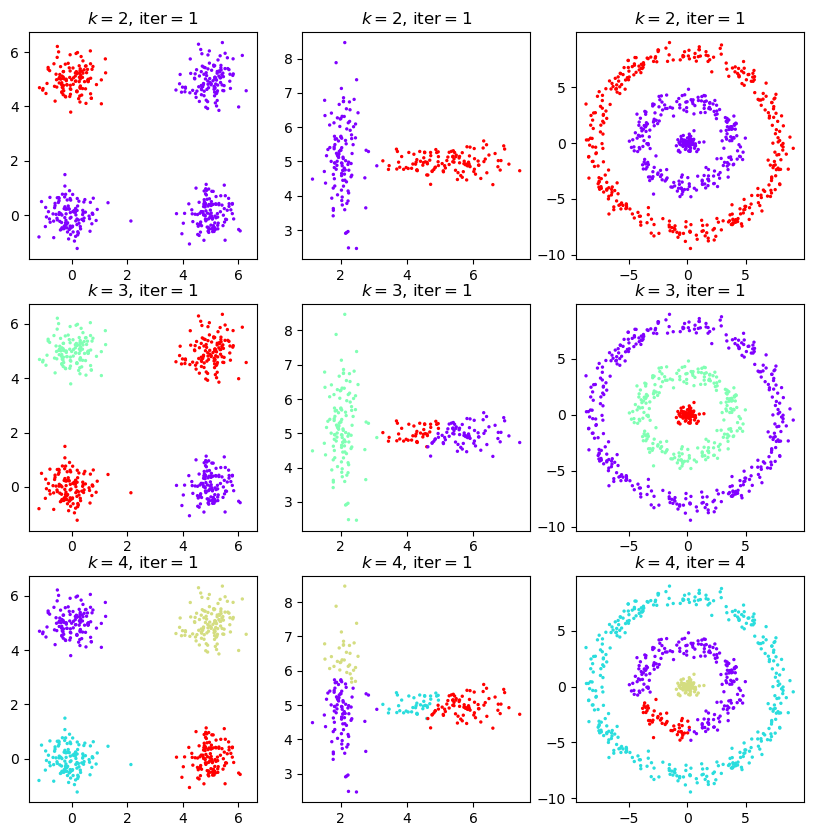

In [29]:
fig, axes = plt.subplots(3, len(datasets)-1, figsize=(10, 10))
for i, k in enumerate([2, 3, 4]): 
    for j, data in enumerate(datasets):
        if j != 2:
            print(f"k = {k}, dataset #{j}")
            labels, iters, err = spectral_clustering(data, k, 'knn', 7, 0.1)
            axes[i, min(j, 2)].scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', s=2)
            axes[i, min(j, 2)].set_title('$k=%d$, iter$=%d$' % (k, iters))

k = 2, dataset #0
k = 2, dataset #1
k = 2, dataset #3
k = 3, dataset #0
k = 3, dataset #1
k = 3, dataset #3
k = 4, dataset #0
k = 4, dataset #1
k = 4, dataset #3


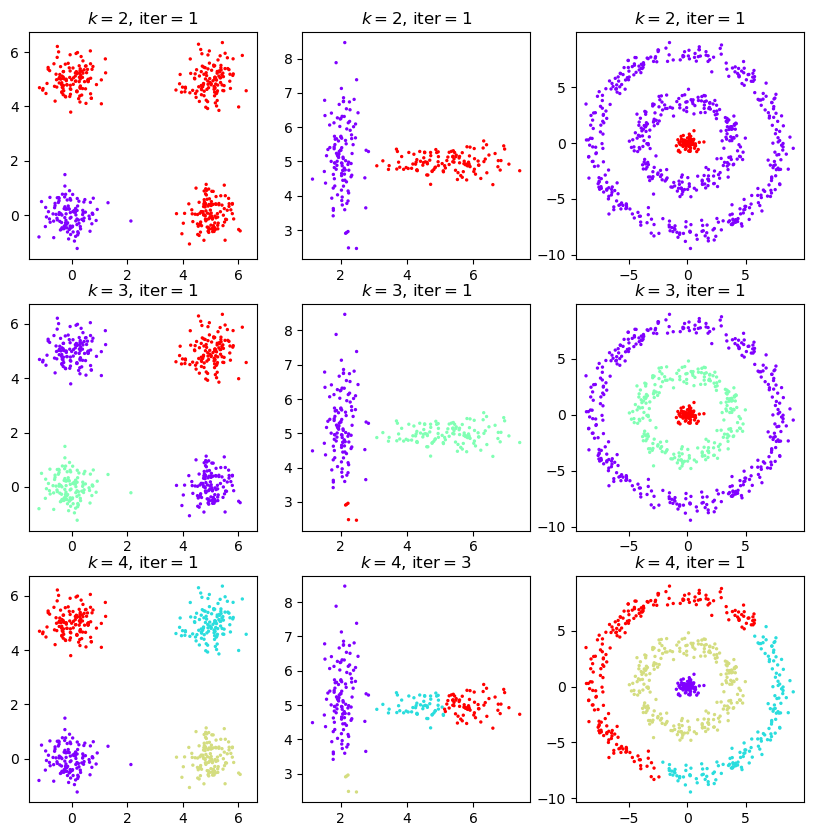

In [30]:
fig, axes = plt.subplots(3, len(datasets)-1, figsize=(10, 10))
for i, k in enumerate([2, 3, 4]):
    for j, data in enumerate(datasets):
        if j != 2:
            print(f"k = {k}, dataset #{j}")
            labels, iters, err = spectral_clustering(data, k, 'Gauss', 8, 0.2)
            axes[i, min(j, 2)].scatter(data[:, 0], data[:, 1], c=labels, cmap='rainbow', s=2)
            axes[i, min(j, 2)].set_title('$k=%d$, iter$=%d$' % (k, iters))

Both methods give us very good results in finding clusters.
- For the k-nearest neighbour graph construction, the algorithm performs well for $k$=7
- For the Gaussian similarity graph, we see that good clusters are found for $\sigma$=0.2

In particular, these two algorithms were able to recover the cluster structure that we are intituively able to observe in the 2 dimensional plots.
We also notice that the number of iterations is always equal to 1 for most cases, which means this method is very efficient.